In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
#Imports needed for spatial merge of data
import shapely
from shapely.geometry import shape, mapping
import geopandas as gpd
from geopandas.tools import sjoin
import json
import folium
from numba import njit
import shapefile as shp
import seaborn as sns

In [2]:
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

In [3]:
#opening the vector map
MA_df = gpd.read_file("../input/mass-gis-dataset/CENSUS2010TRACTS_POLY.shp")
print(MA_df.shape)
MA_df.head()

(1472, 22)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,418003,25021418003,4180.03,Census Tract 4180.03,G5020,1705668.0,2936.0,+42.2350240,...,422.1740,2481,1350,0141872,123764,0003690,0123764,1.708484e+06,6274.185034,"POLYGON ((240678.759 886748.073, 240607.995 88..."
1,25,021,417701,25021417701,4177.01,Census Tract 4177.01,G5020,1543651.0,12275.0,+42.2523398,...,384.4502,5417,2983,0141838,123730,0003683,0123730,1.555821e+06,6229.137913,"POLYGON ((240969.666 890122.806, 240985.156 89..."
2,25,021,417702,25021417702,4177.02,Census Tract 4177.02,G5020,1685529.0,317947.0,+42.2582818,...,416.4918,2765,1109,0141843,123735,0003684,0123735,1.685489e+06,8542.498286,"POLYGON ((242328.221 890545.050, 242276.888 89..."
3,25,021,418102,25021418102,4181.02,Census Tract 4181.02,G5020,771203.0,2371.0,+42.2470410,...,191.1397,3377,1676,0141882,123774,0003693,0123774,7.735182e+05,4540.296101,"POLYGON ((240372.666 888331.030, 240393.057 88..."
4,25,021,418004,25021418004,4180.04,Census Tract 4180.04,G5020,1316466.0,0.0,+42.2383744,...,325.2812,4280,1987,0141874,123766,0003691,0123766,1.316372e+06,5854.497366,"POLYGON ((240687.299 888298.408, 240700.449 88..."


In [4]:
MA_df['NAME10'].unique

<bound method Series.unique of 0       4180.03
1       4177.01
2       4177.02
3       4181.02
4       4180.04
         ...   
1467    7095.01
1468    7095.02
1469    7308.01
1470       7108
1471       7326
Name: NAME10, Length: 1472, dtype: object>

<AxesSubplot:>

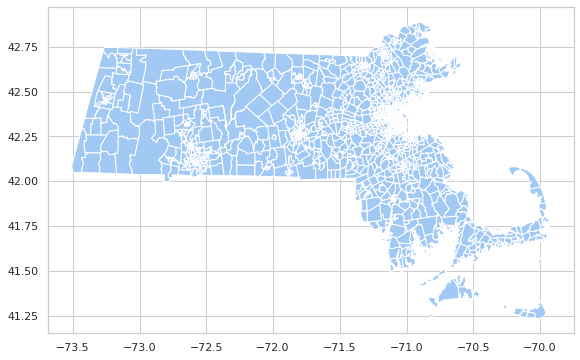

In [5]:
MA_df = MA_df.to_crs('EPSG:4326')
MA_df.plot()

In [6]:
df = pd.read_csv("../input/latlongs/latlongs.csv")
def getLatLong(index, latlongs):
    tupe = eval(latlongs)
    return tupe[index]

df['Lat'] = df.apply(lambda x: getLatLong(0,x['LatLong']), axis=1)
df['Long'] = df.apply(lambda x: getLatLong(1,x['LatLong']), axis=1)
df.head()

,Export Date,Id,Status,Priority,Address Number,Street Name,Work Type,Date Flagged,Flagged By,Modified Date,Last Modified By,Time Open,Description,Comments,Finalized Date,QAlert Id (Do not edit),Address Number Filtered,LatLong,Lat,Long
0,3/4/2021 18:50,12495708,Complete,5,321,Charger Ave,ALL-Street Cleaning,6/29/2020 10:41:49 AM,kimberly.wells@umb.edu,7/3/2020 4:31:51 PM,bguinasso@revere.org,4 days 5 hrs 50 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:51 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056
1,3/4/2021 18:50,12510009,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/1/2020 5:00:00 AM,kimberly.wells@umb.edu,7/3/2020 4:31:55 PM,bguinasso@revere.org,2 days 11 hrs 31 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:55 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056
2,3/4/2021 18:50,12632922,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/22/2020 5:00:00 AM,kimberly.wells@umb.edu,7/24/2020 12:10:42 PM,pargenzio@revere.org,2 days 7 hrs 10 mins,All hands on deck Citywide street cleaning,NaN,7/24/2020 12:10:42 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056
3,3/4/2021 18:50,12785149,Complete,5,321,Charger Ave,ALL-Street Cleaning,8/12/2020 5:00:00 AM,kimberly.wells@umb.edu,8/12/2020 12:32:33 PM,pargenzio@revere.org,0 days 7 hrs 32 mins,All hands on deck Citywide street cleaning,NaN,8/12/2020 12:32:33 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056
4,3/4/2021 18:50,12909944,Complete,5,321,Charger Ave,ALL-Street Cleaning,9/2/2020 5:00:00 AM,kimberly.wells@umb.edu,11/6/2020 2:15:29 PM,bguinasso@revere.org,65 days 9 hrs 15 mins,All hands on deck Citywide street cleaning,NaN,11/6/2020 2:15:29 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056


In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326")
gdf.head()

,Export Date,Id,Status,Priority,Address Number,Street Name,Work Type,Date Flagged,Flagged By,Modified Date,...,Time Open,Description,Comments,Finalized Date,QAlert Id (Do not edit),Address Number Filtered,LatLong,Lat,Long,geometry
0,3/4/2021 18:50,12495708,Complete,5,321,Charger Ave,ALL-Street Cleaning,6/29/2020 10:41:49 AM,kimberly.wells@umb.edu,7/3/2020 4:31:51 PM,...,4 days 5 hrs 50 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:51 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
1,3/4/2021 18:50,12510009,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/1/2020 5:00:00 AM,kimberly.wells@umb.edu,7/3/2020 4:31:55 PM,...,2 days 11 hrs 31 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:55 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
2,3/4/2021 18:50,12632922,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/22/2020 5:00:00 AM,kimberly.wells@umb.edu,7/24/2020 12:10:42 PM,...,2 days 7 hrs 10 mins,All hands on deck Citywide street cleaning,NaN,7/24/2020 12:10:42 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
3,3/4/2021 18:50,12785149,Complete,5,321,Charger Ave,ALL-Street Cleaning,8/12/2020 5:00:00 AM,kimberly.wells@umb.edu,8/12/2020 12:32:33 PM,...,0 days 7 hrs 32 mins,All hands on deck Citywide street cleaning,NaN,8/12/2020 12:32:33 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
4,3/4/2021 18:50,12909944,Complete,5,321,Charger Ave,ALL-Street Cleaning,9/2/2020 5:00:00 AM,kimberly.wells@umb.edu,11/6/2020 2:15:29 PM,...,65 days 9 hrs 15 mins,All hands on deck Citywide street cleaning,NaN,11/6/2020 2:15:29 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)


In [8]:
spatial_merge_df = sjoin(gdf, MA_df, how='left', op='within')
spatial_merge_df.head()

,Export Date,Id,Status,Priority,Address Number,Street Name,Work Type,Date Flagged,Flagged By,Modified Date,...,AREA_SQFT,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN
0,3/4/2021 18:50,12495708,Complete,5,321,Charger Ave,ALL-Street Cleaning,6/29/2020 10:41:49 AM,kimberly.wells@umb.edu,7/3/2020 4:31:51 PM,...,42930593.84,985.5508,9040.0,3816.0,0175590,148580.0,0004019,0148580,3.988399e+06,22381.748888
1,3/4/2021 18:50,12510009,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/1/2020 5:00:00 AM,kimberly.wells@umb.edu,7/3/2020 4:31:55 PM,...,42930593.84,985.5508,9040.0,3816.0,0175590,148580.0,0004019,0148580,3.988399e+06,22381.748888
2,3/4/2021 18:50,12632922,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/22/2020 5:00:00 AM,kimberly.wells@umb.edu,7/24/2020 12:10:42 PM,...,42930593.84,985.5508,9040.0,3816.0,0175590,148580.0,0004019,0148580,3.988399e+06,22381.748888
3,3/4/2021 18:50,12785149,Complete,5,321,Charger Ave,ALL-Street Cleaning,8/12/2020 5:00:00 AM,kimberly.wells@umb.edu,8/12/2020 12:32:33 PM,...,42930593.84,985.5508,9040.0,3816.0,0175590,148580.0,0004019,0148580,3.988399e+06,22381.748888
4,3/4/2021 18:50,12909944,Complete,5,321,Charger Ave,ALL-Street Cleaning,9/2/2020 5:00:00 AM,kimberly.wells@umb.edu,11/6/2020 2:15:29 PM,...,42930593.84,985.5508,9040.0,3816.0,0175590,148580.0,0004019,0148580,3.988399e+06,22381.748888


In [9]:
spatial_merge_df = spatial_merge_df[spatial_merge_df['NAME10'].isnull() != True]

In [10]:
newdf = spatial_merge_df[['NAME10','Work Type']]
print(newdf.shape)
newdf.head()

(58402, 2)


,NAME10,Work Type
0,1703,ALL-Street Cleaning
1,1703,ALL-Street Cleaning
2,1703,ALL-Street Cleaning
3,1703,ALL-Street Cleaning
4,1703,ALL-Street Cleaning


In [156]:
work_type_counts = pd.DataFrame(data=newdf['Work Type'].unique(), columns=['Work Type'])

def get_count(work_type):
    return newdf[newdf['Work Type'] == work_type].shape[0]
work_type_counts['Count'] = work_type_counts.apply(lambda x: get_count(x['Work Type']), axis=1)

work_type_counts.sort_values(by='Count', ascending=False).head(20)

,Work Type,Count
26,Cust-Office Trash,5369
102,Sanitation-Public Barrels •,4622
86,Parks-Mowing •,3062
13,Cust-Clean Bathroom,2384
57,HYWY-Pothole •,2311
25,Cust-Office Recycling,2064
31,DR-Catch Basin Clean •,1944
118,SEW-Pump Station Inspct/Clean,1885
10,Cust-Bldg Maintenance,1797
107,Sanitation-Trash Cart Delivery,1735


In [ ]:
pothole_data = newdf[newdf['Work Type']=='HYWY-Pothole •']
pothole_data.head()

In [ ]:
data_for_map = pd.DataFrame(pothole_data['NAME10'].unique(), columns=["NAME10"])
def get_count(tract):
    return pothole_data[pothole_data['NAME10'] == tract].shape[0]
data_for_map['Num Potholes'] = data_for_map.apply(lambda x: get_count(x['NAME10']), axis=1)
data_for_map.head()

In [96]:
data_for_map_2 = pd.DataFrame(newdf['NAME10'].unique(), columns=["NAME10"])

def insert_columns_for_wt(work_type_data, NAME10):
    return work_type_data[work_type_data['NAME10'] == NAME10].shape[0]

def make_column(work_type):
    work_type_data = newdf[newdf['Work Type']==work_type]
    data_for_map_2[work_type] = data_for_map_2.apply(lambda x: insert_columns_for_wt(work_type_data, x['NAME10']), axis=1)
#     print(work_type_data)
    



work_type_counts.apply(lambda x: make_column(x['Work Type']), axis=1)
data_for_map_2['NAME10Copy'] = data_for_map_2['NAME10']
data_for_map_2

,NAME10,ALL-Street Cleaning,Cptry-Barrel Stands •,Cptry-Board Up •,Cptry-Building Repairs •,Cptry-City Fence Repair •,Cptry-General •,Cptry-Public Stairs •,Cptry-Railings •,Cust-Amer Legion Clean,...,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance,NAME10Copy
0,1703,8,1,0,2,2,0,0,0,1,...,281,12,42,22,5,48,12,11,137,1703
1,1707.02,1,1,0,2,0,0,3,0,0,...,53,3,18,8,4,8,3,4,0,1707.02
2,1702,1,0,1,0,0,1,0,0,0,...,63,11,25,21,5,25,8,4,3,1702
3,1701,0,1,0,3,4,1,0,0,1,...,149,9,31,8,7,42,10,7,2,1701
4,304,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,506,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,506
128,9215,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,9215
129,138,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,138
130,2103,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2103


In [97]:
merged = MA_df.set_index('NAME10').join(data_for_map_2.set_index('NAME10'))
merged

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance,NAME10Copy
NAME10,,,,,,,,,,,,,,,,,,,,,
1,25,025,000100,25025000100,Census Tract 1,G5020,1794942.0,0.0,+42.3614845,-071.1385879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,25,025,100100,25025100100,Census Tract 1001,G5020,1037011.0,874.0,+42.2902498,-071.0873027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,25,025,100200,25025100200,Census Tract 1002,G5020,350592.0,0.0,+42.2848004,-071.0857215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,25,025,100300,25025100300,Census Tract 1003,G5020,491879.0,0.0,+42.2827979,-071.0797972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,25,025,100400,25025100400,Census Tract 1004,G5020,626173.0,0.0,+42.2817870,-071.0708447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817,25,025,981700,25025981700,Census Tract 9817,G5020,314777.0,14973.0,+42.3550872,-071.0657432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9818,25,025,981800,25025981800,Census Tract 9818,G5020,703274.0,393640.0,+42.3231211,-071.1168818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9855,25,005,985500,25005985500,Census Tract 9855,G5020,14893957.0,231316.0,+41.5956952,-071.0128594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# filter out map data
# MA_df[]

name10s = data_for_map_2['NAME10'].to_numpy()
name10s
filtered_df = MA_df[MA_df['NAME10'].isin(name10s)]
revere_df = filtered_df

In [14]:
merged[merged['Cust-Office Trash'].isnull() != True].head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,Water-Mark Out/Dig Safe,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance
NAME10,,,,,,,,,,,,,,,,,,,,,
138,25,001,013800,25001013800,Census Tract 138,G5020,12550246.0,1110312.0,+41.7844010,-070.5377372,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601.01,25,025,160101,25025160101,Census Tract 1601.01,G5020,707020.0,55916.0,+42.3889705,-071.0284298,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,25,025,160200,25025160200,Census Tract 1602,G5020,222152.0,0.0,+42.3897840,-071.0357615,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,25,025,160300,25025160300,Census Tract 1603,G5020,567067.0,294165.0,+42.3880151,-071.0467339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1605.02,25,025,160502,25025160502,Census Tract 1605.02,G5020,1152306.0,282671.0,+42.3965390,-071.0183981,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
fig, ax = plt.subplots(1, 1)
merged.plot(column='Cust-Office Trash', ax=ax, legend=True)

In [ ]:
# map = folium.Map(location = [42.406,-71.010], tiles = "OpenStreetMap", zoom_start = 12)
# map

In [ ]:
# import contextily as ctx

# ax = merged.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column='Cust-Office Trash', legend=True)
# ctx.add_basemap(ax, zoom=12)

In [46]:
cust_office = merged[merged['Cust-Office Trash'].isnull() != True]
cust_office

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,Water-Mark Out/Dig Safe,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance
NAME10,,,,,,,,,,,,,,,,,,,,,
138,25,001,013800,25001013800,Census Tract 138,G5020,12550246.0,1110312.0,+41.7844010,-070.5377372,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601.01,25,025,160101,25025160101,Census Tract 1601.01,G5020,707020.0,55916.0,+42.3889705,-071.0284298,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1602,25,025,160200,25025160200,Census Tract 1602,G5020,222152.0,0.0,+42.3897840,-071.0357615,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1603,25,025,160300,25025160300,Census Tract 1603,G5020,567067.0,294165.0,+42.3880151,-071.0467339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1605.02,25,025,160502,25025160502,Census Tract 1605.02,G5020,1152306.0,282671.0,+42.3965390,-071.0183981,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,25,003,921500,25003921500,Census Tract 9215,G5020,18120354.0,340407.0,+42.6905098,-073.1493635,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9801.01,25,025,980101,25025980101,Census Tract 9801.01,G5020,3191250.0,5488830.0,+42.3265116,-070.9390337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9813,25,025,981300,25025981300,Census Tract 9813,G5020,7157254.0,2015092.0,+42.3611289,-071.0069754,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
max_val = cust_office['Cust-Office Trash'].max()
def normalize_col(val):
    return val / max_val
cust_office['NormalizedVal'] = cust_office.apply(lambda x: normalize_col(x['Cust-Office Trash']), axis=1)
cust_office['NormalizedVal'].head(10)

NAME10
138        0.000000
1601.01    0.000000
1602       0.000000
1603       0.000000
1605.02    0.000000
1606.02    0.000000
1701       0.045446
1702       0.000000
1703       0.000000
1704       0.000000
Name: NormalizedVal, dtype: float64

In [145]:
base_map.save("test.html")

In [160]:
# generates a map for any work type

def normalize_col(val):
    return val / max_val

def any_cat(work_type):
    work_type_data_maps = merged[merged[work_type].isnull() != True]
    max_val = work_type_data_maps[work_type].max()
    work_type_data_maps['NormalizedVal'] = work_type_data_maps.apply(lambda x: normalize_col(x[work_type]), axis=1)
    
    default_location=[42.408428, -71.011993]

    base_map = folium.Map(location=default_location, tiles="Stamen Toner", zoom_start=13)

    for i, r in work_type_data_maps.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = geo_j.replace('"properties": {}', '"properties": {"opacity": '+str(min(1,r['NormalizedVal']*5))+'}')
   
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange', 'fillOpacity':x['properties']['opacity'], 'opacity': 0.2})
        folium.Popup(work_type+': ' + str(r[work_type])).add_to(geo_j)
        geo_j.add_to(base_map)
    return base_map

bm = any_cat('Sanitation-Public Barrels •')
bm

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [151]:
import os
os.mkdir('out')

In [155]:
def gen_and_save_map(work_type):
    work_str = work_type.replace(" ", "").replace("/", "-").replace("•", "")
    print(work_str)
    bm = any_cat(work_type)
    bm.save('./out/'+work_str+".html")

work_type_counts.apply(lambda x: gen_and_save_map(x['Work Type']), axis=1)

ALL-StreetCleaning
Cptry-BarrelStands
Cptry-BoardUp
Cptry-BuildingRepairs
Cptry-CityFenceRepair
Cptry-General
Cptry-PublicStairs
Cptry-Railings
Cust-AmerLegionClean
Cust-BathroomResupply
Cust-BldgMaintenance
Cust-Boiler-Heatcheck
Cust-ChambersCheck
Cust-CleanBathroom
Cust-CleanDitch
Cust-CleanElevator
Cust-CleanMayor'sOfc
Cust-Cleaning
Cust-EquipmentMaintenance
Cust-Events
Cust-FurnitureMove-Removal
Cust-Inmates-Roca
Cust-MailDuty
Cust-Mowing
Cust-Newspapers
Cust-OfficeRecycling
Cust-OfficeTrash
Cust-Open-CloseCityHall
Cust-ResupplyOffices
Cust-SoapDispensers
Cust-WashFloor
DR-CatchBasinClean
DR-CatchBasinInspect
DR-CatchBasinRebuild
DR-Clvrt&TrashRackClean
DR-ClvrtRepair
DR-DrainPumpStation
DR-InspctDrainContractor
DR-LateralDrainClean
DR-MarkOut-DigSafe
DR-MissingGrate
DR-MS4OutfallInspect
DR-Other
DR-StormCCTV
DR-StormCulvertLocate
DR-StormMainCleaning
DR-StormManholeInspection
DR-StormManholeLocate
DR-StormOutfall
DR-TideGateCleaning
DR-TideGateMaintenance
HYWY-ClearDebris-Pavement

0      None
1      None
2      None
3      None
4      None
       ... 
178    None
179    None
180    None
181    None
182    None
Length: 183, dtype: object

In [ ]:
# Be sure to take out cust-categories, water-pther and public barrels bc they are fixed locations

#
